In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

import pandas_datareader as pdr
import matplotlib.pyplot as plt

data_amd = yf.download('AMD', '2024-02-15', end = '2024-04-27') 
data_amd.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-02-20,171.139999,171.809998,162.000000,165.690002,165.690002,66550000
2024-02-21,162.740005,164.899994,161.809998,164.289993,164.289993,48774600
2024-02-22,173.199997,183.830002,172.000000,181.860001,181.860001,100684700
2024-02-23,181.860001,183.800003,174.550003,176.520004,176.520004,69207400
2024-02-26,178.779999,179.839996,174.809998,176.009995,176.009995,45435100


In [2]:
data_amd['2_SMA'] = data_amd['Close'].rolling(window=2).mean()
data_amd['5_SMA'] = data_amd['Close'].rolling(window=5).mean()

data_amd = data_amd[data_amd['5_SMA'].notna()]

# SMA trade calls
Trade_Buy=[]
Trade_Sell=[]
for i in range(len(data_amd)-1):
    if ((data_amd['2_SMA'].values[i] < data_amd['5_SMA'].values[i]) & (data_amd['2_SMA'].values[i+1] > data_amd['5_SMA'].values[i+1])):
        print("Trade Call for {row} is Buy.".format(row=data_amd.index[i].date()))
        Trade_Buy.append(i)
    elif ((data_amd['2_SMA'].values[i] > data_amd['5_SMA'].values[i]) & (data_amd['2_SMA'].values[i+1] < data_amd['5_SMA'].values[i+1])):
        print("Trade Call for {row} is Sell.".format(row=data_amd.index[i].date()))
        Trade_Sell.append(i)

Trade Call for 2024-02-27 is Sell.
Trade Call for 2024-02-28 is Buy.
Trade Call for 2024-03-08 is Sell.
Trade Call for 2024-03-27 is Buy.
Trade Call for 2024-04-02 is Sell.
Trade Call for 2024-04-09 is Buy.
Trade Call for 2024-04-10 is Sell.
Trade Call for 2024-04-23 is Buy.


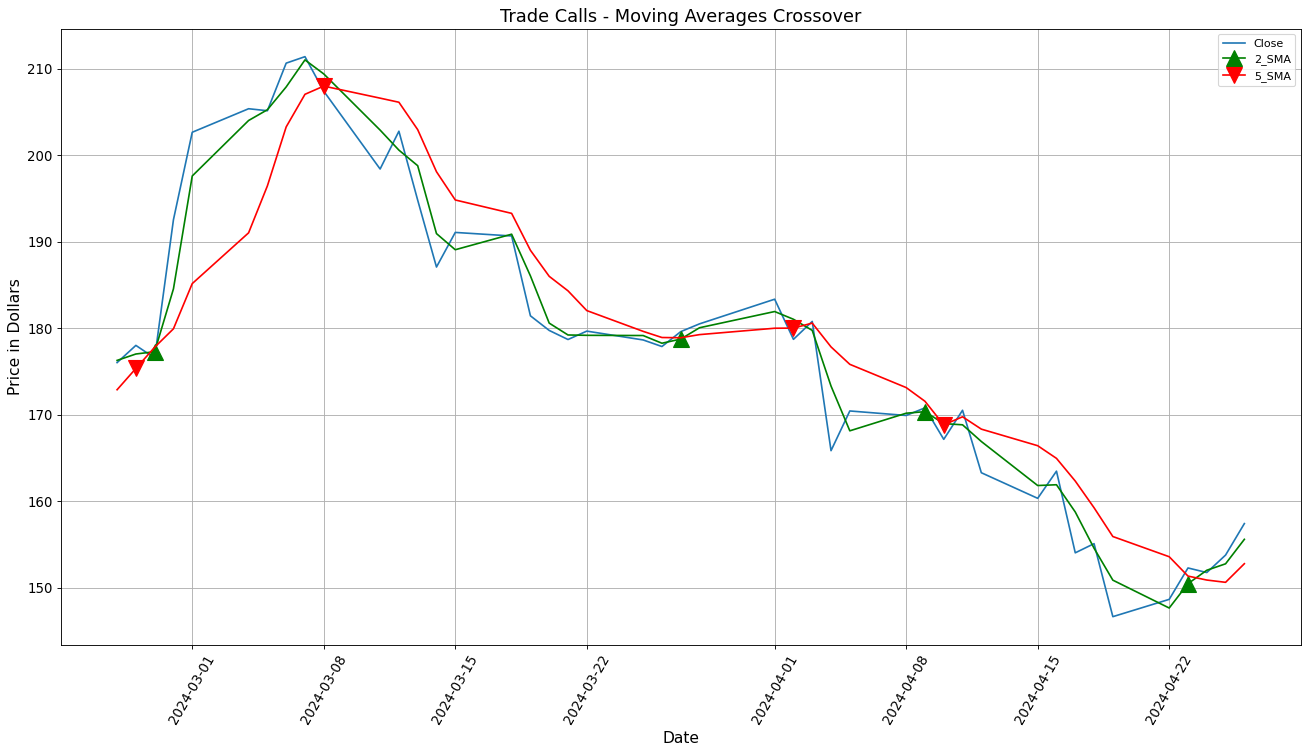

In [3]:
plt.figure(figsize=(20, 10),dpi=80)
plt.plot(data_amd.index, data_amd['Close'])
plt.plot(data_amd.index, data_amd['2_SMA'],'-^', markevery=Trade_Buy, ms=15, color='green')
plt.plot(data_amd.index, data_amd['5_SMA'],'-v', markevery=Trade_Sell, ms=15, color='red')
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price in Dollars', fontsize = 14)
plt.xticks(rotation=60,fontsize=12)  # Fixed rotation value
plt.yticks(fontsize=12)
plt.title('Trade Calls - Moving Averages Crossover', fontsize = 16)
plt.legend(['Close','2_SMA','5_SMA'])
plt.grid()
plt.show() 

In [4]:
import requests 
# Define the endpoint
url = 'https://newsapi.org/v2/everything?'

# Specify the query and number of returns
parameters = {
    'q': 'AMD', # query phrase
    'sortBy': 'popularity', # articles from popular sources and publishers come first
    'pageSize': 100,  # maximum is 100 for developer version
    'apiKey': 'b5609d2514664fdd8345d0c8f83267cb', # your own API key
}

# Make the request
response = requests.get(url, params=parameters)

# Convert the response to JSON format and store it in dataframe
data = pd.DataFrame(response.json())

news_df = pd.concat([data['articles'].apply(pd.Series)], axis=1)

final_news = news_df.loc[:,['publishedAt','title']]
final_news['publishedAt'] = pd.to_datetime(final_news['publishedAt'])
final_news.sort_values(by='publishedAt',inplace=True)

# Import BDay to determine business day's dates
from pandas.tseries.offsets import BDay

# to get the business day for which particular news headline should be used to make trade calls
def get_trade_open(date):
    curr_date_open = pd.to_datetime(date).floor('d').replace(hour=13,minute=30) - BDay(0)
    curr_date_close = pd.to_datetime(date).floor('d').replace(hour=20,minute=0) - BDay(0)
    
    prev_date_close = (curr_date_open - BDay()).replace(hour=20,minute=0)
    next_date_open = (curr_date_close + BDay()).replace(hour=13,minute=30)
    
    if ((pd.to_datetime(date)>=prev_date_close) & (pd.to_datetime(date)<curr_date_open)):
        return curr_date_open
    elif ((pd.to_datetime(date)>=curr_date_close) & (pd.to_datetime(date)<next_date_open)):
        return next_date_open
    else:
        return None
      
 # Apply the above function to get the trading time for each news headline
final_news["trading_time"] = final_news["publishedAt"].apply(get_trade_open)

final_news = final_news[pd.notnull(final_news['trading_time'])]
final_news['Date'] = pd.to_datetime(pd.to_datetime(final_news['trading_time']).dt.date)

In [5]:
# Sentiment analysis using VADER
analyzer = SentimentIntensityAnalyzer()
cs = []

# Calculate sentiment for each headline
for row in range(len(final_news)):
    cs.append(analyzer.polarity_scores(final_news['title'].iloc[row])['compound'])

final_news['compound_vader_score'] = cs

# Filter out rows with a neutral sentiment score of 0
final_news = final_news[(final_news[['compound_vader_score']] != 0).all(axis=1)].reset_index(drop=True)

# Show the first few rows of the updated news DataFrame
final_news.head()





NameError: name 'SentimentIntensityAnalyzer' is not defined

In [6]:
unique_dates = final_news['Date'].unique()
grouped_dates = final_news.groupby(['Date'])
keys_dates = list(grouped_dates.groups.keys())

max_cs = []
min_cs = []

for key in grouped_dates.groups.keys():
    data = grouped_dates.get_group(key)
    if data["compound_vader_score"].max() > 0:
        max_cs.append(data["compound_vader_score"].max())
    elif data["compound_vader_score"].max() < 0:
        max_cs.append(0)
    
    if data["compound_vader_score"].min() < 0:
        min_cs.append(data["compound_vader_score"].min())
    elif data["compound_vader_score"].min() > 0:
        min_cs.append(0)
    
extreme_scores_dict = {'Date':keys_dates,'max_scores':max_cs,'min_scores':min_cs}
extreme_scores_df = pd.DataFrame(extreme_scores_dict)

In [ ]:
final_scores = []
for i in range(len(extreme_scores_df)):
    final_scores.append(extreme_scores_df['max_scores'].values[i] + extreme_scores_df['min_scores'].values[i])

extreme_scores_df['final_scores'] = final_scores

extreme_scores_df.head()

In [8]:
vader_Buy=[]
vader_Sell=[]
for i in range(len(extreme_scores_df)):
    if extreme_scores_df['final_scores'].values[i] > 0.20:
        print("Trade Call for {row} is Buy.".format(row=extreme_scores_df['Date'].iloc[i].date()))
        vader_Buy.append(extreme_scores_df['Date'].iloc[i].date())
    elif extreme_scores_df['final_scores'].values[i] < -0.20:
        print("Trade Call for {row} is Sell.".format(row=extreme_scores_df['Date'].iloc[i].date()))
        vader_Sell.append(extreme_scores_df['Date'].iloc[i].date())

In [ ]:
vader_buy = []
for i in range(len(data_amd)):
    if data_amd.index[i].date() in vader_Buy:
        vader_buy.append(i)
        
vader_sell = []
for i in range(len(data_amd)):
    if data_amd.index[i].date() in vader_Sell:
        vader_sell.append(i)
        
plt.figure(figsize=(20, 10),dpi=80)
plt.plot(data_amd.index, data_amd['Close'],'-^', markevery=vader_buy, ms=15, color='green')
plt.plot(data_amd.index, data_amd['Close'],'-v', markevery=vader_sell, ms=15, color='red')
plt.plot(data_amd.index, data_amd['Close'])
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price in Dollars', fontsize = 14)
plt.xticks(rotation=60,fontsize=12)
plt.yticks(fontsize=12)
plt.title('Trade Calls - VADER', fontsize = 16)
plt.legend(['Buy','Sell','Close'])
plt.grid()
plt.show() 

In [ ]:
#prioritising SMA signals
final_buy = list(set(Trade_Buy + vader_buy) - set(Trade_Sell)) 
final_sell = list(set(Trade_Sell + vader_sell) - set(Trade_Buy))

plt.figure(figsize=(20, 10),dpi=80)
plt.plot(data_amd.index, data_amd['2_SMA'], color='blue')
plt.plot(data_amd.index, data_amd['5_SMA'], color='orange')
plt.plot(data_amd.index, data_amd['Close'],'-^', markevery=final_buy, ms=15, color='green')
plt.plot(data_amd.index, data_amd['Close'],'-v', markevery=final_sell, ms=15, color='red')
plt.plot(data_amd.index, data_amd['Close'])
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price in Dollars', fontsize = 14)
plt.xticks(rotation=60,fontsize=12)
plt.yticks(fontsize=12)
plt.title('Trade Calls - MERGED', fontsize = 16)
plt.legend(['2_SMA','5_SMA','Buy','Sell','Close'])
plt.grid()
plt.show() 